# Classification model

[Pyspark blog](https://bryancutler.github.io/)

[ML w/ Pyspark](https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa)

[GitHub event types](https://developer.github.com/v3/activity/events/types/)

[Churn modeling](https://www.urbanairship.com/blog/churn-prediction-our-machine-learning-model)

[Interpreting Trees](https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27)

[Intro to Boosted Trees](https://xgboost.readthedocs.io/en/latest/tutorials/model.html#why-introduce-the-general-principle)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import pickle

from pyspark.sql.types import DoubleType
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, Binarizer#, OneHotEncoderEstimator, StringIndexer
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel, GBTClassifier, RandomForestClassifier
from pyspark.sql import functions as F

from pyspark.sql.functions import to_timestamp, datediff, unix_timestamp

import helper as h

### Model name and filter flags for segmentation

In [2]:
company_filter = 1
high_low_filter = 0
if company_filter:
    model_name = 'company_' + str(company_filter)
else:
    model_name = 'company_' + str(company_filter) + 'high_low_' + str(high_low_filter)

## Data ingestion 

In [3]:
_data = h.get_merged_data('classification')

% of users dropped 4.698526359485271


In [4]:
_data.head()

Row(login='0loky0', followers_count=0, following_count=1, blog=0, company=0, created_at=datetime.datetime(2011, 5, 24, 16, 15, 25), public_repos_count=7, public_gists_count=0, hireable=1, recency=1788, updated_at=datetime.datetime(2019, 1, 9, 10, 3, 59), time_between_first_last_event=11, last_event=datetime.datetime(2016, 4, 15, 6, 14, 3), first_event=datetime.datetime(2016, 4, 4, 14, 44, 57), frequency=19, second_period_event_count=0, CommitCommentEvent_count=0, CreateEvent_count=5, DeleteEvent_count=0, ForkEvent_count=2, GollumEvent_count=0, IssueCommentEvent_count=0, IssuesEvent_count=0, MemberEvent_count=0, PublicEvent_count=0, PullRequestEvent_count=0, PullRequestReviewCommentEvent_count=0, PushEvent_count=12, ReleaseEvent_count=0, WatchEvent_count=0)

In [5]:
#_data = _data.withColumn("end_date", to_timestamp('2016-06-02 23:59:59+00:00'))
#_data = _data.withColumn("T", datediff(_data.end_data, _data.created_at))    

In [6]:
_data.printSchema()

root
 |-- login: string (nullable = true)
 |-- followers_count: integer (nullable = true)
 |-- following_count: integer (nullable = true)
 |-- blog: integer (nullable = true)
 |-- company: integer (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- public_repos_count: integer (nullable = true)
 |-- public_gists_count: integer (nullable = true)
 |-- hireable: integer (nullable = true)
 |-- recency: integer (nullable = true)
 |-- updated_at: timestamp (nullable = true)
 |-- time_between_first_last_event: integer (nullable = true)
 |-- last_event: timestamp (nullable = true)
 |-- first_event: timestamp (nullable = true)
 |-- frequency: integer (nullable = true)
 |-- second_period_event_count: integer (nullable = true)
 |-- CommitCommentEvent_count: integer (nullable = true)
 |-- CreateEvent_count: integer (nullable = true)
 |-- DeleteEvent_count: integer (nullable = true)
 |-- ForkEvent_count: integer (nullable = true)
 |-- GollumEvent_count: integer (nullable = true)
 |--

### Load K-Means classifier

Classify users as high or low use.

In [7]:
_data = h.add_high_low_flag(_data, False)

### Scale data

In [8]:
_data = h.feature_scaling(_data)

### Filter and segment users

In [9]:
#churn_data = _data
churn_data = _data.filter((_data.company == company_filter)) 
if not company_filter:
    churn_data = churn_data[churn_data.high_low_user == high_low_filter]

### Summarize

In [10]:
h.print_user_churn(churn_data)

23.86% of users churned in second period


In [11]:
numeric_features = [t[0] for t in churn_data.dtypes if t[1] == 'int' or t[1] == 'double']
numeric_features.remove('second_period_event_count')
numeric_features.remove('frequency')
#numeric_features.remove('non_passive_events')
#numeric_features.remove('public_repos_gists')
numeric_features.remove('public_repos_count')
numeric_features.remove('public_gists_count')
numeric_features.remove('high_low_user')
numeric_features.remove('company')
numeric_features.remove('time_between_first_last_event')

numeric_features.remove('GollumEvent_count')
numeric_features.remove('CommitCommentEvent_count')
numeric_features.remove('MemberEvent_count')
numeric_features.remove('PublicEvent_count')
numeric_features.remove('ReleaseEvent_count')
numeric_features += ['PublicEvent_count_bin']
numeric_features += ['ReleaseEvent_count_bin']
#churn_data.select(numeric_features).describe().toPandas().transpose()

## Build PySpark pipeline

In [12]:
stages = []
# binarizer needs double type or it throws an error.
churn_data = churn_data.withColumn("second_period_event_count", 
                                   churn_data.second_period_event_count.cast(DoubleType()))
binarizer = Binarizer(threshold=0.5, 
                      inputCol="second_period_event_count", 
                      outputCol="label")

churn_data = churn_data.withColumn("PublicEvent_count", 
                                   churn_data.PublicEvent_count.cast(DoubleType()))
binarizer2 = Binarizer(threshold=0.5, 
                      inputCol="PublicEvent_count", 
                      outputCol="PublicEvent_count_bin")

churn_data = churn_data.withColumn("ReleaseEvent_count", 
                                   churn_data.ReleaseEvent_count.cast(DoubleType()))
binarizer3 = Binarizer(threshold=0.5, 
                      inputCol="ReleaseEvent_count", 
                      outputCol="ReleaseEvent_count_bin")

stages += [binarizer]
stages += [binarizer2]
stages += [binarizer3]
assembler = VectorAssembler(inputCols=numeric_features, 
                            outputCol="features").setHandleInvalid("skip")
stages += [assembler]

In [13]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(churn_data)
churn_data = pipelineModel.transform(churn_data)
selectedCols = ['label', 'features'] + numeric_features
churn_data = churn_data.select(selectedCols)
churn_data.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- followers_count: double (nullable = true)
 |-- following_count: double (nullable = true)
 |-- blog: integer (nullable = true)
 |-- hireable: integer (nullable = true)
 |-- recency: double (nullable = true)
 |-- CreateEvent_count: double (nullable = true)
 |-- DeleteEvent_count: double (nullable = true)
 |-- ForkEvent_count: double (nullable = true)
 |-- IssueCommentEvent_count: double (nullable = true)
 |-- IssuesEvent_count: double (nullable = true)
 |-- PullRequestEvent_count: double (nullable = true)
 |-- PullRequestReviewCommentEvent_count: double (nullable = true)
 |-- PushEvent_count: double (nullable = true)
 |-- WatchEvent_count: double (nullable = true)
 |-- PublicEvent_count_bin: double (nullable = true)
 |-- ReleaseEvent_count_bin: double (nullable = true)



In [14]:
# save pipeline
pipeline.write().overwrite().save('pipeline')

### Training/Test split

In [15]:
train, test = churn_data.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: {0}".format(train.count()))
print("Test Dataset Count: {0}".format(test.count()))

Training Dataset Count: 19973
Test Dataset Count: 8516


## Logistic Regression

In [16]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=50,
                        #standardization=False,
                        regParam=0.03,
                        #elasticNetParam=0.5,
                       )
lrModel = lr.fit(train)

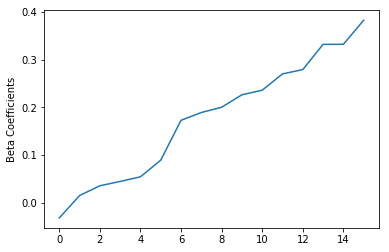

In [17]:
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

In [18]:
pd.DataFrame({'features': numeric_features, # np.asarray(numeric_features)[lrModel.coefficients.indices], 
              'weights': lrModel.coefficients.values}
            ).sort_values(by='weights', ascending=False)


,features,weights
13,WatchEvent_count,0.382768
0,followers_count,0.332298
15,ReleaseEvent_count_bin,0.332227
7,ForkEvent_count,0.279323
12,PushEvent_count,0.270244
8,IssueCommentEvent_count,0.236050
14,PublicEvent_count_bin,0.226466
9,IssuesEvent_count,0.200330
1,following_count,0.189322
4,recency,0.173036


Training set areaUnderROC: 0.819168468535769


/home/brian/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


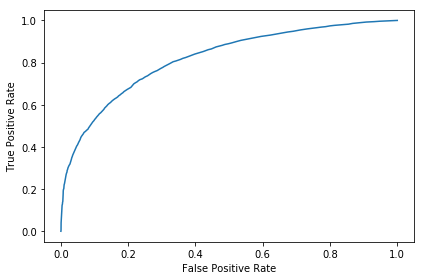

In [19]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()

fig, ax = plt.subplots(1,1)
fig.set_tight_layout(True)
pd.DataFrame({'features': numeric_features, # np.asarray(numeric_features)[lrModel.coefficients.indices], 
              'weights': lrModel.coefficients.values}
            ).sort_values(by='weights', ascending=False)
ax.plot(roc['FPR'],roc['TPR'])
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
#ax.title('ROC Curve')
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))


fig.savefig('figures/logistic_regression_ROC' + model_name + '.png')
fig.savefig('figures/logistic_regression_ROC' + model_name + '.pdf')

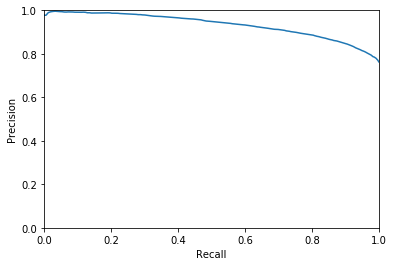

In [20]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.show()

In [21]:
#lrModel._java_obj.setThreshold(0.75)
print('Threshold: {0}'.format(lrModel._java_obj.getThreshold()))
predictions = lrModel.transform(test)
show_cols = ['followers_count', 'blog', 
             'label', 'rawPrediction', 'prediction', 'probability']
predictions.select(show_cols).show(10)

Threshold: 0.5
+------------------+----+-----+--------------------+----------+--------------------+
|   followers_count|blog|label|       rawPrediction|prediction|         probability|
+------------------+----+-----+--------------------+----------+--------------------+
| 5.780743515792329|   1|  0.0|[-2.0695522581025...|       1.0|[0.11209159325612...|
|1.9459101490553132|   1|  0.0|[-1.5106301451443...|       1.0|[0.18084542445092...|
|1.0986122886681098|   1|  0.0|[-2.7774217243776...|       1.0|[0.05855652818071...|
|1.0986122886681098|   0|  0.0|[-1.8385461581029...|       1.0|[0.13722332663863...|
|1.0986122886681098|   0|  0.0|[-0.5142265960058...|       1.0|[0.37420323662052...|
|1.0986122886681098|   1|  0.0|[-0.5425643529345...|       1.0|[0.36759125030993...|
|               0.0|   1|  0.0|[1.19863605418875...|       0.0|[0.76828205625984...|
|               0.0|   1|  0.0|[-0.0420970651974...|       1.0|[0.48947728765143...|
|               0.0|   1|  0.0|[-0.2506049058729..

In [22]:
h.eval_metrics(predictions)

TP, FN | FP, TN
6199, 286 | 1460, 571
---------------------------
Precision: 0.809
Recall:    0.956
Accuracy:  0.795
F1-score:  0.8766


In [23]:
lrModel.write().overwrite().save('lrModel_' + model_name)

## Gradient Boosted Trees

[Gradient Boost vs XGboost](https://datascience.stackexchange.com/questions/16904/gbm-vs-xgboost-key-differences)

In [25]:
gbt = GBTClassifier(maxIter=50)
gbtModel = gbt.fit(train)
h.write_tree_to_file(gbtModel.toDebugString, 'gbt_trees_' + model_name)

predictions = gbtModel.transform(test)
predictions.select(show_cols).show(10)

h.eval_metrics(predictions)

Saved to fullfile
+------------------+----+-----+--------------------+----------+--------------------+
|   followers_count|blog|label|       rawPrediction|prediction|         probability|
+------------------+----+-----+--------------------+----------+--------------------+
| 1.791759469228055|   1|  0.0|[-0.6529512287021...|       1.0|[0.21317331904302...|
|2.6390573296152584|   1|  0.0|[-1.3754902121981...|       1.0|[0.06003130336156...|
|0.6931471805599453|   1|  0.0|[0.13069208624285...|       0.0|[0.56497652156521...|
|1.3862943611198906|   1|  0.0|[-0.8157100500880...|       1.0|[0.16363591459763...|
|1.0986122886681098|   1|  0.0|[-1.5357166531507...|       1.0|[0.04430110387560...|
|2.0794415416798357|   0|  0.0|[-0.2680742287832...|       1.0|[0.36908400318422...|
|2.3978952727983707|   0|  0.0|[-0.6171884788582...|       1.0|[0.22541627401020...|
|0.6931471805599453|   0|  0.0|[-0.1460425312677...|       1.0|[0.42749348603924...|
|  2.70805020110221|   0|  0.0|[-1.391326243367

### Feature importances
[pyspark feature imortances doc](http://spark.apache.org/docs/2.1.1/api/python/pyspark.ml.html#pyspark.ml.classification.GBTClassificationModel.featureImportances):

Estimate of the importance of each feature.

Each feature’s importance is the average of its importance across all trees in the ensemble. The importance vector is normalized to sum to 1. This method is suggested by Hastie et al. (Hastie, Tibshirani, Friedman. “The Elements of Statistical Learning, 2nd Edition.” 2001.) and follows the implementation from scikit-learn.

In [26]:
print(gbtModel.featureImportances.indices)
numeric_features = np.asarray(numeric_features)
pd.DataFrame([numeric_features[gbtModel.featureImportances.indices], 
              gbtModel.featureImportances.values]).T.sort_values(by=[1], ascending=False)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


,0,1
4,recency,0.256713
13,WatchEvent_count,0.115006
0,followers_count,0.0969165
12,PushEvent_count,0.096248
9,IssuesEvent_count,0.0892106
1,following_count,0.0701746
5,CreateEvent_count,0.0692474
7,ForkEvent_count,0.0637637
8,IssueCommentEvent_count,0.0433739
10,PullRequestEvent_count,0.0269669


In [59]:
'''evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(
    evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))'''

'evaluator = BinaryClassificationEvaluator()\nprint("Test Area Under ROC: " + str(\n    evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))'

## Random forest classification

In [60]:
'''rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
h.write_tree_to_file(rfModel.toDebugString, 'rf_trees_' + model_name)
predictions = rfModel.transform(test)
predictions.select(show_cols).show(10)
h.eval_metrics(predictions)'''

"rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')\nrfModel = rf.fit(train)\nh.write_tree_to_file(rfModel.toDebugString, 'rf_trees_' + model_name)\npredictions = rfModel.transform(test)\npredictions.select(show_cols).show(10)\nh.eval_metrics(predictions)"

In [27]:
examples = pd.DataFrame(churn_data.take(500), columns=churn_data.columns)

In [1]:
import matplotlib.pylab as plt
examples = examples.drop(['label'], axis=1)
fig, ax = plt.subplots(8, 2, figsize=(6, 30))
examples.hist(ax=ax)

NameError: name 'examples' is not defined

## Grid search with cross validation

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()

paramGrid = (ParamGridBuilder()
             .addGrid(lrModel.elasticNetParam, [0, 0.8, 0.08])
             .addGrid(lrModel.regParam, [0, 0.3, 0.003])
             .addGrid(lrModel.maxIter, [50, 100])
             .build())
cv = CrossValidator(estimator=lrModel, estimatorParamMaps=paramGrid, 
                    evaluator=evaluator, numFolds=5)

# Run cross validations
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

In [ ]:
h.eval_metrics(predictions)